# Query Sequence Analysis (Deep Learning)

This notebook focuses on sequence analysis, when presented with a workload schedule / sequence of queries. In an average day to day work activity, particular query patterns can be discerned. This pattern distinction allows us to discern which queries will be susceptible to execution over time, allowing us to know ahead of time which queries will be executed against the database.

## Data Preprocessing

### Module Installation and Importing Libraries

In [211]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# keras
import keras as ke
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding, Flatten
from keras.utils import np_utils
print('keras: %s' % ke.__version__)
import math

scipy: 1.1.0
numpy: 1.15.2
pandas: 0.23.4
sklearn: 0.19.0
keras: 2.2.4


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [212]:
#
# Experiment Config
tpcds='TPCDS1' # Schema upon which to operate test
lag=3 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
#
test_split=.2 # Denotes which Data Split to operate under when it comes to training / validation
#
# Net Config
epochs=2
batch_size=10

### Read data from file into Pandas Dataframes

In [213]:
#
# Open Data
rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/v2/rep_hist_snapshot.csv'
#rep_hist_snapshot_path = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds + '/v2/rep_hist_snapshot.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
#
print(rep_hist_snapshot_df.columns.values)

['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Changing Matrix Shapes

Changes dataframe shape, in an attempt to drop all numeric data. Below's aggregated data is done so on:
* SNAP_ID
* INSTANCE_NUMBER
* DBID
* SQL_ID

In [214]:
print("Shape Before Aggregation: " + str(rep_hist_snapshot_df.shape))
#
# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT) and drop all numeric
df = rep_hist_snapshot_df.groupby(['SNAP_ID'])['SQL_ID'].apply(list).reset_index()
#
print("Shape After Aggregation: " + str(df.shape))
print(type(df))
print(df.head(100))

Shape Before Aggregation: (2230, 90)
Shape After Aggregation: (27, 2)
<class 'pandas.core.frame.DataFrame'>
    SNAP_ID                                             SQL_ID
0     37137  [03ggjrmy0wa1w, 0aq14dznn91rg, 0f60bzgt9127c, ...
1     37138  [06dymzb481vnd, 13a9r2xkx1bxb, 14f5ngrj3cc5h, ...
2     37139  [01d5n1nm17r2h, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
3     37140  [04kug40zbu4dm, 06g9mhm5ba7tt, 0y080mnfaqk3u, ...
4     37141  [06dymzb481vnd, 0y080mnfaqk3u, 0y080mnfaqk3u, ...
5     37142  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
6     37143  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
7     37144  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
8     37145  [06g9mhm5ba7tt, 0kcbwucxmazcp, 0kkhhb2w93cx0, ...
9     37146  [06g9mhm5ba7tt, 0hhmdwwgxbw0r, 0kcbwucxmazcp, ...
10    37147  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
11    37148  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
12    37149  [01tp87bk1t2zv, 06dymzb481vnd, 0kcbwucxmazcp, ...
13    3715

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [215]:
df.sort_index(ascending=True,inplace=True)
print(df.shape)
print(df.head(100))

(27, 2)
    SNAP_ID                                             SQL_ID
0     37137  [03ggjrmy0wa1w, 0aq14dznn91rg, 0f60bzgt9127c, ...
1     37138  [06dymzb481vnd, 13a9r2xkx1bxb, 14f5ngrj3cc5h, ...
2     37139  [01d5n1nm17r2h, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
3     37140  [04kug40zbu4dm, 06g9mhm5ba7tt, 0y080mnfaqk3u, ...
4     37141  [06dymzb481vnd, 0y080mnfaqk3u, 0y080mnfaqk3u, ...
5     37142  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
6     37143  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
7     37144  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
8     37145  [06g9mhm5ba7tt, 0kcbwucxmazcp, 0kkhhb2w93cx0, ...
9     37146  [06g9mhm5ba7tt, 0hhmdwwgxbw0r, 0kcbwucxmazcp, ...
10    37147  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
11    37148  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
12    37149  [01tp87bk1t2zv, 06dymzb481vnd, 0kcbwucxmazcp, ...
13    37150  [06g9mhm5ba7tt, 0kcbwucxmazcp, 0kkhhb2w93cx0, ...
14    37151  [06g9mhm5ba7tt, 09vrdx888wvvb, 0a7

### Univariate Selection

This sextion treats the dataset as a univariate dataset. Therefore the SNAP_ID pertaining to each set of SQL_IDs is removed, with the intent of future classifiers training solely on past SQL executions

In [216]:
print(df.shape)
del df['SNAP_ID']
print(df.shape)

(27, 2)
(27, 1)


### Label Encoding

Since this experiment deals with prediction of upcoming SQL_IDs, respectice SQL_ID strings need to labelled as a numeric representation. Label Encoder will be used here to convert SQL_ID's into a numeric format, which are in turn used for training. Evaluation (achieved predictions) is done so also in numeric format, at which point the label encoder is eventually used to decode back the labels into the original, respetive SQL_ID representation.

This section of the experiment additionally converts the targetted label into a binarized version of the previous achieved categorical numeric values.

* https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

In [217]:
class LabelEncoder:
    """
    Scikit Label Encoder was acting up with the following error whilst using the transform function, even though I tripled 
    checked that the passed data was exactly the same as the one used for training:
    
    * https://stackoverflow.com/questions/46288517/getting-valueerror-y-contains-new-labels-when-using-scikit-learns-labelencoder
    
    So I have rebuilt a similar functionality to categorize my data into numeric digits, as the LabelEncoder is supposed to do.
    """
    #
    def __init__(self):
        self.__class_map = {}
        self.__integer_counter = 0
    #
    def fit(self, X):
        """
        :param - X: python list
        """
        for val in X:
            if val not in self.__class_map:
                self.__class_map[val] = self.__integer_counter
                self.__integer_counter += 1
    #
    def transform(self, X):
        """
        param - X: python list
        """
        encoded_map = []
        for val in X:
            if val in self.__class_map:
                value = self.__class_map[val]
                encoded_map.append(value)
            else:
                raise ValueError('Label Mismatch - Encountered a label which was not trained on.')
        return encoded_map
    #
    def get_class_map(self):
        """
        Returns original classes as a list
        """
        class_map = []
        for key, value in self.__class_map.items():
            class_map.append(key)
        return class_map
    #
    def get_encoded_map(self):
        """
        Returns class encodings as a list
        """
        encoded_map = []
        for key, value in self.__class_map.items():
            encoded_map.append(value)
        return encoded_map

In [218]:
print(df.shape)
print(df.head(10))
le = LabelEncoder()
for index, row in df.iterrows():
    sql_id_list = row['SQL_ID']
    le.fit(sql_id_list)
for index, row in df.iterrows():
    sql_id_list = row['SQL_ID']
    transformed_list = le.transform(sql_id_list)
    df['SQL_ID'].iloc[index] = transformed_list 
#
print("\n----------------------------------\n\nAvailable Classes:")
print('Total SQL_ID Classes: ' + str(len(le.get_class_map())))
print(le.get_class_map()[:10])
print(df.shape)
print(df.head(10))

(27, 1)
                                              SQL_ID
0  [03ggjrmy0wa1w, 0aq14dznn91rg, 0f60bzgt9127c, ...
1  [06dymzb481vnd, 13a9r2xkx1bxb, 14f5ngrj3cc5h, ...
2  [01d5n1nm17r2h, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
3  [04kug40zbu4dm, 06g9mhm5ba7tt, 0y080mnfaqk3u, ...
4  [06dymzb481vnd, 0y080mnfaqk3u, 0y080mnfaqk3u, ...
5  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
6  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
7  [01tp87bk1t2zv, 01tp87bk1t2zv, 01tp87bk1t2zv, ...
8  [06g9mhm5ba7tt, 0kcbwucxmazcp, 0kkhhb2w93cx0, ...
9  [06g9mhm5ba7tt, 0hhmdwwgxbw0r, 0kcbwucxmazcp, ...

----------------------------------

Available Classes:
Total SQL_ID Classes: 379
['03ggjrmy0wa1w', '0aq14dznn91rg', '0f60bzgt9127c', '0ga8vk4nftz45', '0hdquu87pydzk', '1jhyrdp21f2q6', '1p5grz1gs7fjq', '1r7b985mxqj71', '29mjaymwt5p6d', '2hnpu9m861609']
(27, 1)
                                              SQL_ID
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
1  [47, 48, 49, 6, 50, 51, 52, 53, 54, 55,

### Data Normalization

A note regarding normalization. Normalization for this experiment was purposely skipped, since training & testing data will be one-hot encoded.

### Feature Padding

Since there isn't a fixed number of SQL_ID's per SNAP_ID, each set of SQL_IDs need to be padded so as to assume an equal number if SQL_IDs for the purpose of model fitting.

In [219]:
print("Length at index 0: " + str(len(df['SQL_ID'].iloc[0])))
print(df['SQL_ID'].iloc[0])
print("Length at index 1: " + str(len(df['SQL_ID'].iloc[1])))
print(df['SQL_ID'].iloc[1])
print("Length at index 2: " + str(len(df['SQL_ID'].iloc[2])))
print(df['SQL_ID'].iloc[2])
#
# Retrieve largest length
def pad_datamatrix(df):
    """
    Iterates over dataframe and pads SQL_ID lists accordingly with -1 values
    """
    row_sizes = []
    for index, row in df.iterrows():
        row_sizes.append(len(row['SQL_ID']))
    max_row_size = max(row_sizes)
    #
    # Pad Dataframe Values
    i = 0
    for index, row in df.iterrows():
        length = len(row['SQL_ID'])
        diff = max_row_size - length
        if diff != 0:
            for j in range(length, max_row_size):
                df['SQL_ID'].iloc[i] = np.append(df['SQL_ID'].iloc[i], -1) # Appends -1 to padded values
        # print("Length at index " + str(i) + ": " + str(df['SQL_ID'].iloc[i].size))
        i += 1
    return df
#
df = pad_datamatrix(df)
#
print('\n\n------------------------------------------\n\n')
print("Length at index 0: " + str(len(df['SQL_ID'].iloc[0])))
print(df['SQL_ID'].iloc[0])
print("Length at index 1: " + str(len(df['SQL_ID'].iloc[1])))
print(df['SQL_ID'].iloc[1])
print("Length at index 2: " + str(len(df['SQL_ID'].iloc[2])))
print(df['SQL_ID'].iloc[2])

Length at index 0: 47
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
Length at index 1: 55
[47, 48, 49, 6, 50, 51, 52, 53, 54, 55, 56, 57, 11, 58, 59, 13, 60, 61, 62, 19, 63, 64, 65, 22, 66, 67, 24, 68, 69, 70, 71, 26, 72, 73, 29, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 39, 86, 87, 88, 42, 43, 89, 90]
Length at index 2: 98
[91, 92, 92, 92, 93, 94, 95, 96, 97, 6, 98, 99, 99, 99, 100, 101, 102, 103, 104, 105, 13, 106, 107, 108, 108, 109, 110, 111, 112, 113, 114, 115, 116, 19, 117, 118, 118, 119, 120, 121, 122, 22, 123, 124, 24, 125, 126, 26, 127, 128, 29, 129, 130, 130, 131, 131, 132, 133, 134, 135, 136, 136, 137, 138, 139, 140, 141, 142, 143, 144, 144, 145, 146, 147, 148, 149, 149, 149, 149, 150, 151, 151, 151, 152, 39, 153, 154, 155, 40, 156, 157, 158, 43, 159, 159, 159, 159, 160]


------------------------------------------


Length at index 0: 10

### Expand Feature Lists

Expand Feature Lists, where in each list element is represented as it's own features. Total feature count here equates as follows:

* Features = (lag * SQL_ID per SNAP_ID count) + SQL_ID per SNAP_ID count
* Labels = lag * SQL_ID per SNAP_ID count

In [220]:
def sequence2features(df):
    """
    Converts pandas sequences into full fledged columns/features
    """
    feature_count = len(df[df.columns[0]].iloc[0])
    for column_name in df.columns:
        data_matrix = []
        new_values = df[column_name].values
        #
        new_values = np.stack(new_values, axis=0 )
        #
        for i in range(1,feature_count+1):
            new_column_name = column_name + "_"+str(i)
            df[new_column_name] = new_values[:,i-1]
        #
        # Drop original list columns
        df.drop(column_name, inplace=True, axis=1)
    return df
#
print('Features')
print('Before: ' + str(df.shape))
df = sequence2features(df=df)
print('After: ' + str(df.shape))

Features
Before: (27, 1)
After: (27, 104)


### One Hot Encoding

One hot encoding target labels for deep learning application

* https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [221]:
class OneHotEncoder:
    #
    def __init__(self, classes):
        self.__mapper = pd.DataFrame(columns=classes)
    #
    def fit_transform(self, X):
        class_types = self.__mapper.columns
        for row in X:
            temp_row = []
            for i in range(len(class_types)):
                if class_types[i] in row:
                    temp_row.append(1)
                else:
                    temp_row.append(0)
            self.__mapper.loc[len(self.__mapper)] = temp_row
        return self.__mapper
    #
    def get_classes(self):
        return self.__mapper.columns
    #
    def get_unique_values(self):
        return np.unique(self.__mapper.values)

In [222]:
#
# One Hot Encoding train data
ohe = OneHotEncoder(classes=le.get_encoded_map())
print('Training Data:')
print("Before One Hot Encoding: " + str(df.shape))
df = ohe.fit_transform(X=df.values)
print("After One Hot Encoding: " + str(df.shape))
print(df)
print('Value type: ' + str(ohe.get_unique_values()))
print(type(df))

Training Data:
Before One Hot Encoding: (27, 104)
After One Hot Encoding: (27, 379)
   0   1   2   3   4   5   6   7   8   9   ... 369 370 371 372 373 374 375  \
0    1   1   1   1   1   1   1   1   1   1 ...   0   0   0   0   0   0   0   
1    0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
2    0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
3    0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
4    0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
5    0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
6    0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
7    0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
8    0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
9    0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   
10   0   0   0   0   0   0   1   0   0   0 ...   0   0   0

### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [223]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if n_in != 0:
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
#
def remove_n_time_steps(data, n=1):
    if n == 0:
        return data
    df = data
    headers = df.columns
    dropped_headers = []
    #
    for i in range(1,n+1):
        for header in headers:
            if "(t+"+str(i)+")" in header:
                dropped_headers.append(str(header))
    #
    return df.drop(dropped_headers, axis=1) 
#
# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, lag)
#
# Seperate labels from features
x_columns, y_columns = [], []
for col in shifted_df.columns:
    if '+' in col:
        y_columns.append(col)
    else:
        x_columns.append(col)
#
y_df = shifted_df[y_columns]
X_df = shifted_df[x_columns]
print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print(type(X_df))
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)
print(type(y_df))
#
# Delete middle timesteps
X_df = remove_n_time_steps(data=X_df, n=lag)
print('\n-------------\nFeatures After Time Shift')
print(X_df.columns)
print(X_df.shape)
print(type(X_df))
# y_df = remove_n_time_steps(data=y_df, n=lag)
print('\n-------------\nLabels After Time Shift')
print(y_df.columns)
print(y_df.shape)
print(type(y_df))


-------------
Features
Index(['var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var9(t-3)', 'var10(t-3)',
       ...
       'var370(t)', 'var371(t)', 'var372(t)', 'var373(t)', 'var374(t)',
       'var375(t)', 'var376(t)', 'var377(t)', 'var378(t)', 'var379(t)'],
      dtype='object', length=1516)
(21, 1516)
<class 'pandas.core.frame.DataFrame'>

-------------
Labels
Index(['var1(t+1)', 'var2(t+1)', 'var3(t+1)', 'var4(t+1)', 'var5(t+1)',
       'var6(t+1)', 'var7(t+1)', 'var8(t+1)', 'var9(t+1)', 'var10(t+1)',
       ...
       'var370(t+3)', 'var371(t+3)', 'var372(t+3)', 'var373(t+3)',
       'var374(t+3)', 'var375(t+3)', 'var376(t+3)', 'var377(t+3)',
       'var378(t+3)', 'var379(t+3)'],
      dtype='object', length=1137)
(21, 1137)
<class 'pandas.core.frame.DataFrame'>

-------------
Features After Time Shift
Index(['var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var6(t-3)', 'var7(t-3)', 'var8(t-3)'

## Deep Learning Model (Many to Many Approach)

### Designing the network

The Keras library provides wrapper classes to allow you to use neural network models developed with Keras in scikit-learn.

There is a KerasClassifier class in Keras that can be used as an Estimator in scikit-learn, the base type of model in the library. The KerasClassifier takes the name of a function as an argument. This function must return the constructed neural network model, ready for training.

The hidden layer uses a rectifier activation function which is a good practice. Because we used a one-hot encoding for our SQL_ID dataset, the output layer must create n output values, one for each SQL_ID class. The output value with the largest value will be taken as the class predicted by the model.

The network topology of this simple one-layer neural network can be summarized as:

* n_inputs = Number of input neurons dependent on SQL_ID Features (Vector Width)
* n_hidden = Number of hidden layer neurons (This will almost be the same as n_inputs, pending testing)
* n_output = Number of output neurons dependent on SQL_ID Classes.

n_inputs -> [n_hidden] -> n_output

### Relavent Links

Network structure pointers [https://www.heatonresearch.com/2017/06/01/hidden-layers.html]. Rough heuristics to start with:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

--------------------------------------------------------------------------------------------

* https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
* https://arxiv.org/pdf/1312.6026.pdf
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8141873

In [224]:
#
# KerasModel Class
class KerasModel:
    """
    Long Short Term Memory Neural Net Class
    """

    #
    def __init__(self, X, y, optimizer, loss, activation):
        """
        Initiating the class creates a net with the established parameters
        :param X_train - Training data used to train the model
        :param y_train - Test data used to test the model
        :param layers - A list of values, where in each value denotes a layer, and the number of neurons for that layer
        :param loss_function - Function used to measure fitting of model (predicted from actual)
        :param optimizer - Function used to optimize the model (eg: Gradient Descent)
        """
        self.model = Sequential()
        self.model.add(Dense(X.shape[1], input_dim=X.shape[1], activation=activation))
        self.model.add(Dense(y.shape[1], activation=activation))
        self.model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
        print(self.model.summary())
    #
    def fit_model(self, X_train, X_test, y_train, y_test, epochs=50, batch_size=50, verbose=2, shuffle=False,
                  plot=False):
        """
        Fit data to model & validate. Trains a number of epochs.
        """
        history = self.model.fit(x=X_train,
                                 y=y_train,
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_data=(X_test, y_test),
                                 verbose=verbose,
                                 shuffle=shuffle)
        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            plt.plot(history.history['acc'], label='train')
            plt.plot(history.history['val_acc'], label='validation')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

    #
    def predict(self, X):
        yhat = self.model.predict(X)
        yhat[yhat>=0.5] = 1
        yhat[yhat<0.5] = 0
        return yhat

    #
    def predict_and_evaluate(self, X, y, lag, plot=False):
        yhat = self.predict(X)
        yhat = yhat.astype(int)
        y = y.astype(int)
        #
        # F1-Score Evaluation
        feature_count = int(y.shape[1] / lag)
        acc_score, f_score = .0,.0
        counter = 1
        for i in range(y.shape[1]):
            acc = accuracy_score(y[:,i], yhat[:,i], normalize=True)
            acc_score += acc
            f1 = f1_score(y[:,i], yhat[:,i], average='micro') 
            f_score += f1
            if i % (feature_count-1) == 0 and i != 0:
                acc_score = acc_score/feature_count # Averaging accuracy accross total sql_ids for that particular timestep
                f_score = f_score/feature_count # Averaging f-score accross total sql_ids for that particular timestep
                print('Test Accuracy LAG value [' + str(counter) + ']: ' +  str(acc_score))
                print('Test FScore LAG value [' + str(counter) + ']: ' +  str(f_score) + "\n")
                acc_score, f_score = .0,.0
                counter += 1
    #
    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, batch, depth, epoch, score, time_train):
        file_exists = os.path.isfile(path)
        with open(path, 'a') as csvfile:
            headers = ['iteration', 'lag', 'test_split', 'batch', 'depth', 'epoch', 'score', 'time_train']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'lag': lag,
                             'test_split': test_split,
                             'batch': batch,
                             'depth':depth,
                             'epoch':epoch,
                             'score': score,
                             'time_train': time_train})

X_train shape [(16, 1516)] Type - [<class 'numpy.ndarray'>]
y_train shape [(16, 1137)] Type - [<class 'numpy.ndarray'>]
X_validate shape [(2, 1516)] Type - [<class 'numpy.ndarray'>]
y_validate shape [(2, 1137)] Type - [<class 'numpy.ndarray'>]
X_test shape [(3, 1516)] Type - [<class 'numpy.ndarray'>]
y_test shape [(3, 1137)] Type - [<class 'numpy.ndarray'>]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------------------------------------------
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------------------------------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

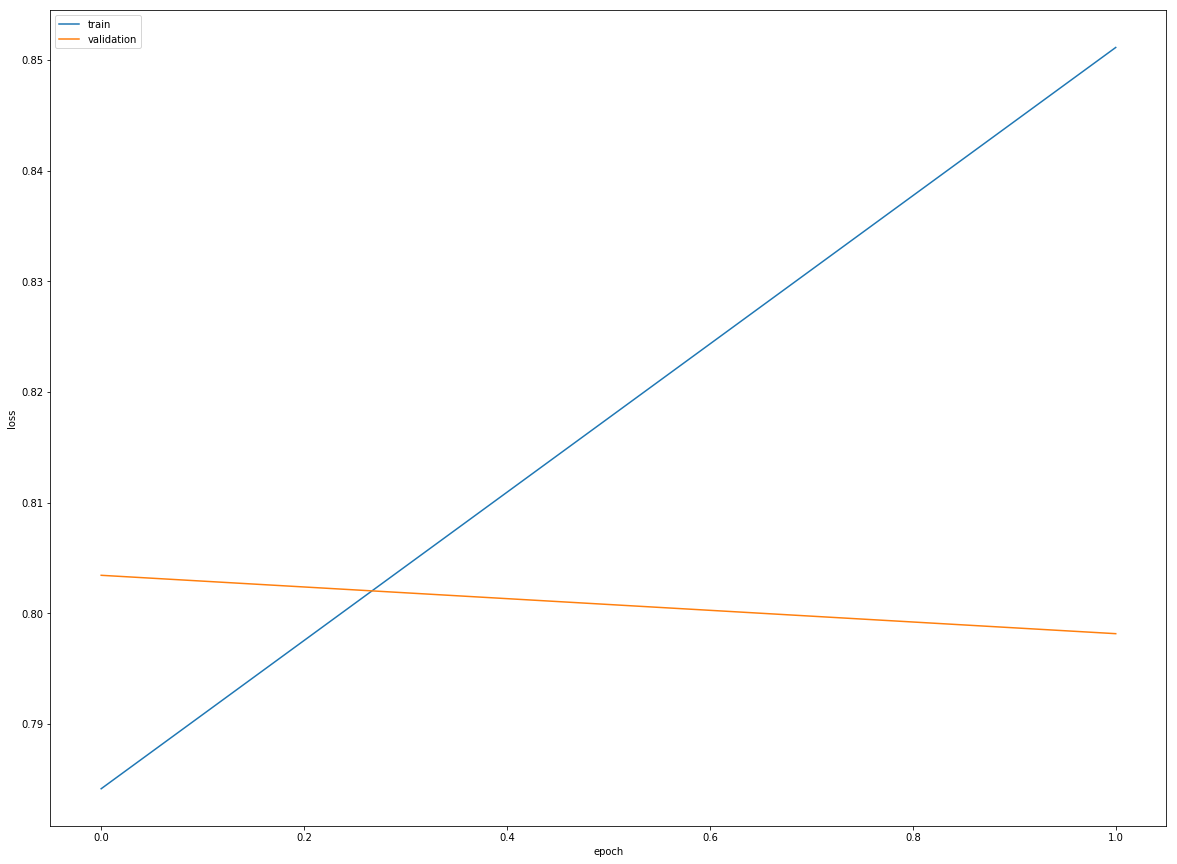

Test Accuracy LAG value [1]: 0.8245382585751979
Test FScore LAG value [1]: 0.8245382585751979

Test Accuracy LAG value [2]: 0.8047493403693932
Test FScore LAG value [2]: 0.8047493403693932

Test Accuracy LAG value [3]: 0.7889182058047494
Test FScore LAG value [3]: 0.7889182058047494

Train on 2 samples, validate on 3 samples
Epoch 1/2
 - 0s - loss: 1.9458 - acc: 0.7982 - val_loss: 1.9690 - val_acc: 0.8024
Epoch 2/2
 - 0s - loss: 1.8823 - acc: 0.8127 - val_loss: 1.9966 - val_acc: 0.7960


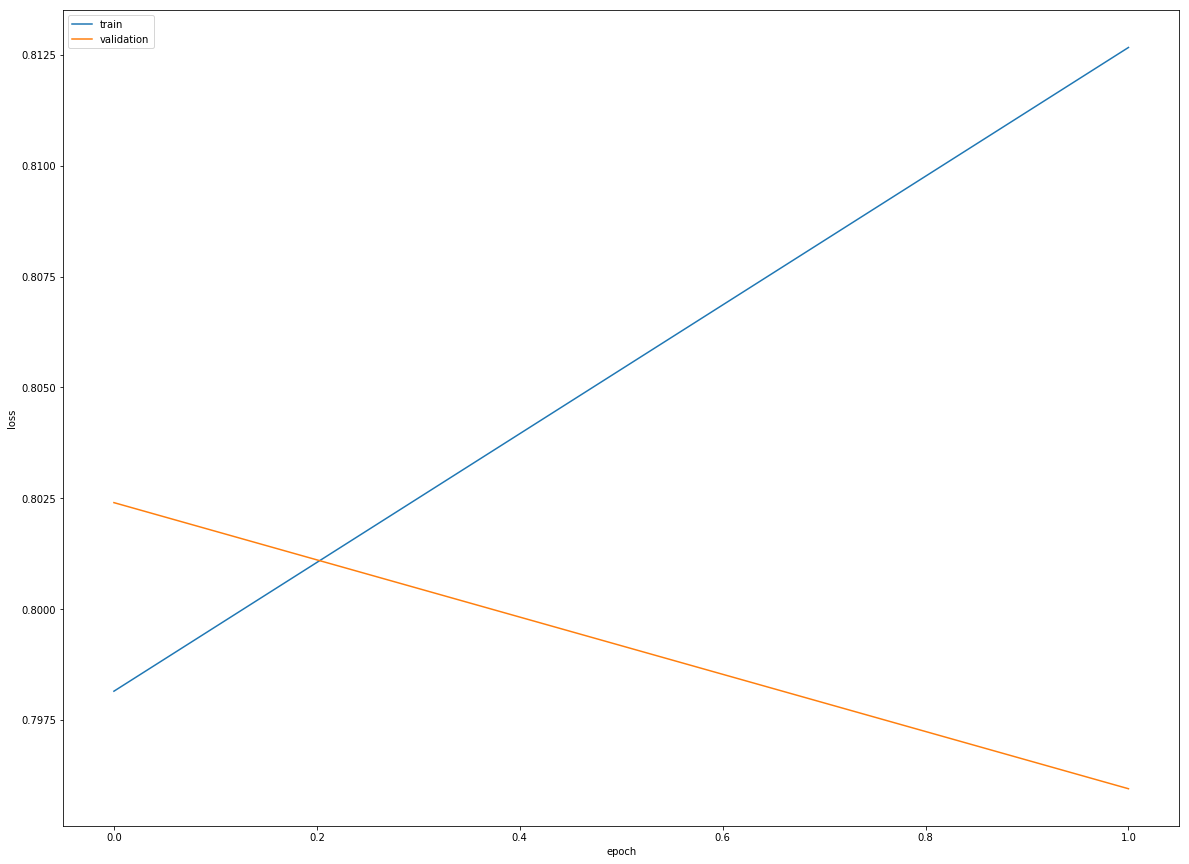

Test Accuracy LAG value [1]: 0.8170624450307824
Test FScore LAG value [1]: 0.8170624450307824

Test Accuracy LAG value [2]: 0.7985927880386969
Test FScore LAG value [2]: 0.7985927880386969

Test Accuracy LAG value [3]: 0.8847845206684256
Test FScore LAG value [3]: 0.8847845206684256

Wall time: 4 s


In [225]:
%%time
y_labels = y_df.columns
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - [" + str(type(X_train)) + "]")
print("y_train shape [" + str(y_train.shape) + "] Type - [" + str(type(y_train)) + "]")
#
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
#
X_validate = X_validate.values
y_validate = y_validate.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - [" + str(type(X_validate)) + "]")
print("y_validate shape [" + str(y_validate.shape) + "] Type - [" + str(type(y_validate)) + "]")
#
X_test = X_test.values
y_test = y_test.values
print("X_test shape [" + str(X_test.shape) + "] Type - [" + str(type(X_test)) + "]")
print("y_test shape [" + str(y_test.shape) + "] Type - [" + str(type(y_test)) + "]")
print("\n")
#
print(X_train[0:5])
print(y_train[0:5])
print('------------------------------------------------------------')
print(X_validate[0:5])
print(y_validate[0:5])
print('------------------------------------------------------------')
print(X_test[0:5])
print(y_test[0:5])
#
# X_train = np.reshape(X_train,(X_train.shape[0], 1, X_train.shape[1]))
# X_validate = np.reshape(X_validate,(X_validate.shape[0], 1, X_validate.shape[1]))
# X_test = np.reshape(X_test,(X_test.shape[0], 1, X_test.shape[1]))
# print('\nReshaping Training Frames')
# print("X_train shape [" + str(X_train.shape) + "] Type - [" + str(type(X_train)) + "]")
# print("X_validate shape [" + str(X_validate.shape) + "] Type - [" + str(type(X_validate)) + "]")
# print("X_test shape [" + str(X_test.shape) + "] Type - [" + str(type(X_test)) + "]")
#
# Train on discrete data (Train > Validation)
discrete_model = KerasModel(X=X_train,
                            y=y_train,
                            optimizer='adam',
                            loss='binary_crossentropy',
                            activation='relu')
discrete_model.fit_model(X_train=X_train,
                         X_test=X_validate,
                         y_train=y_train,
                         y_test=y_validate,
                         epochs=epochs, 
                         batch_size=batch_size,
                         verbose=2, 
                         shuffle=False,
                         plot=True)
discrete_model.predict_and_evaluate(X=X_validate,
                                    y=y_validate,
                                    lag=lag,
                                    plot=True)
#
# Train on discrete data (Train + Validation > Test)
discrete_model.fit_model(X_train=X_validate,
                         X_test=X_test,
                         y_train=y_validate,
                         y_test=y_test,
                         epochs=epochs, 
                         batch_size=batch_size,
                         verbose=2, 
                         shuffle=False,
                         plot=True)
discrete_model.predict_and_evaluate(X=X_test,
                                    y=y_test,
                                    lag=lag,
                                    plot=True)